In [1]:
import jax
jax.config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/dlux/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import pickle as p
import equinox as eqx
import optax
import functools as ft

In [3]:
import webbpsf

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-051 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-055
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [26]:
from dLux import *
import sys
sys.path.append('../../src')
from helpers import *
from bayes import *

from tqdm.notebook import tqdm
from dLux.zernike import zernike_basis
from model_layers import toliman_layers
from chainconsumer import ChainConsumer
from astropy.io import fits

In [27]:
plt.figure()
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120
# plt.rcParams.keys()

<Figure size 720x480 with 0 Axes>

In [25]:
class InvertY(eqx.Module):
    def __call__(self, params_dict):
        wf = params_dict["Wavefront"]
        wf = wf.invert_y()
        params_dict["Wavefront"] = wf
        return params_dict
    
class InvertX(eqx.Module):
    def __call__(self, params_dict):
        wf = params_dict["Wavefront"]
        wf = wf.invert_x()
        params_dict["Wavefront"] = wf
        return params_dict
    
class InvertXY(eqx.Module):
    
    def __call__(self, params_dict):
        wf = params_dict["Wavefront"]
        wf = wf.invert_x_and_y()
        params_dict["Wavefront"] = wf
        return params_dict

In [60]:
def get_layers(planes, print_vals=False):

    pscale = planes[0].pixelscale.to('m/pix').value
    npix = planes[0].npix
    diam = pscale*npix

    layers = [CreateWavefront(npix, diam)]

    for i in range(len(planes)):
        plane = planes[i]
        
        if print_vals:
            print(i, plane.planetype)
            print(plane)

        if not isinstance(plane.__dict__['opd'], int):
            if len(plane.__dict__['opd'].shape) == 2:

                ampl = plane.amplitude
                opd = plane.opd

                layers.append(ApplyAperture(ampl))
                layers.append(ApplyOPD(opd))

        if str(plane) == "Coordinate Inversion in y axis":
            layers.append(InvertY())
            layers.append(NormaliseWavefront())

        if str(plane.planetype) == "PlaneType.detector":        
            det_npix = (plane.fov_pixels * plane.oversample).value
            pscale = plane.pixelscale.to('radian/pix').value / plane.oversample
            layers.append(AngularMFT(pscale, det_npix))

        if print_vals:
            print()

    layers.append(InvertXY())
    
    return layers

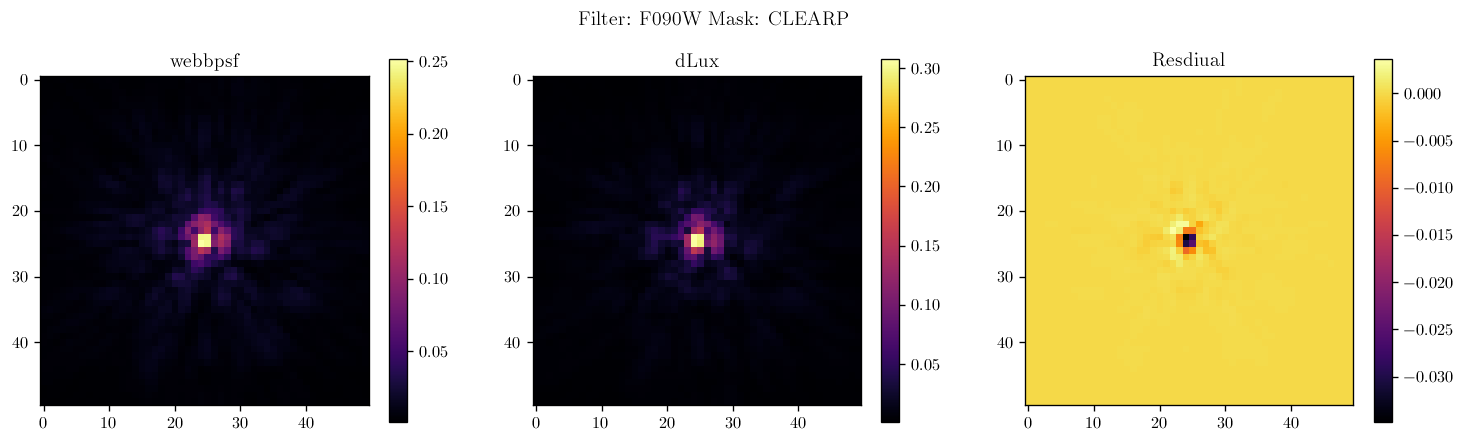

In [ ]:
OSYS = webbpsf.NIRISS()
# OSYS = webbpsf.NIRCam()

filter_list = OSYS.filter_list
mask_list = OSYS.pupil_mask_list

# for i in range(len(filter_list)):
for i in range(3):

    filter_in = filter_list[i]
    for j in range(len(mask_list)-1):
        mask_in = OSYS.pupil_mask_list[j]


        OSYS.filter =  filter_in
        OSYS.pupil_mask = mask_in
        psf_fits = OSYS.calc_psf(oversample=4)
        extras = OSYS.calc_psf(return_all=True)
        planes = OSYS.optsys.planes

        layers = get_layers(planes, print_vals=False)

        wavels = np.array(extras['wavelens'])
        weights = np.array(extras['weights'])
        osys = OpticalSystem(layers, wavels=wavels, weights=weights)
        psf = osys()

        c = psf.shape[0]//2
        s = 25

        psf_p = psf_fits[0].data[c-s:c+s, c-s:c+s]
        psf_d = psf[c-s:c+s, c-s:c+s]
        res = psf_p - psf_d

        plt.figure(figsize=(15, 4))
        plt.suptitle("Filter: {} \t Mask: {}".format(filter_in, mask_in))
        
        plt.subplot(1, 3, 1)
        plt.title("webbpsf")
        plt.imshow(psf_p**0.5)
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.title("dLux")
        plt.imshow(psf_d**0.5)
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.title("Resdiual")
        plt.imshow(res)
        plt.colorbar()
        plt.show()

In [ ]:
pspec = np.abs(np.fft.fftshift(np.fft.fft2(psf)))**0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(psf**0.2)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(pspec)
plt.colorbar()
plt.show()

In [ ]:
for i in range(len(planes)):
    plane = planes[i]
    print(i)
    print(plane.planetype)
    print(plane)
    print(plane.oversample)
    
    if not isinstance(plane.__dict__['opd'], int):
        if len(plane.__dict__['opd'].shape) == 2:

            ampl = plane.amplitude
            opd = plane.opd

            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(ampl)
            plt.colorbar()

            plt.subplot(1, 2, 2)
            plt.imshow(opd)
            plt.colorbar()
            plt.show()

    print()